In [42]:
# This notebook does classification of the wines between good and bad.

# Following this, then in the p3workshop running pip install let me install the modules
#http://echrislynch.com/2019/02/01/adding-an-environment-to-jupyter-notebooks/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from IPython import display
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from xgboost import XGBRegressor
from xgboost import XGBClassifier

from tensorflow import keras
from tensorflow.keras import layers, callbacks


sns.set_palette("bright")

# Import the wine data set
data = pd.read_csv('wineQualityReds.csv', usecols=(np.arange(12)+1))

# Fix outliers in chlorides and residual sugar for better visualization
data["chlorides"] = pd.Series([min(x, 0.14) for x in data["chlorides"]])
data["residual.sugar"] = pd.Series([min(x, 4.) for x in data["residual.sugar"]])
data["total.sulfur.dioxide"] = pd.Series([min(x, 170.) for x in data["total.sulfur.dioxide"]])
data["sulphates"] = pd.Series([min(x, 1.4) for x in data["sulphates"]])

data["GoodBad"] = (np.sign(data["quality"]-6.5)+1.)/2.

In [43]:
# Define a function for preping data for the classification algorithm.
#print(data.columns)
def prep_for_classifier(data):

    data_prep = data.copy(deep=True)
    y = data_prep.pop("GoodBad")
    data_prep = data_prep.drop("quality", axis=1)
    #print(data_prep.head())
    X_train, X_test, y_train, y_test = train_test_split(data_prep, y, test_size=0.3, random_state=11121)
    std_scaler = StandardScaler()
    X_cols = data_prep.columns
    X_train = std_scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=X_cols)
    X_test = std_scaler.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=X_cols)
    
    return [X_train, X_test, y_train, y_test]
    

In [56]:
# Fit the XGB Classifier to the original data set.
X_train, X_test, y_train, y_test = prep_for_classifier(data)
#print(X_train.head())
xgbmodel = XGBClassifier(n_estimators = 200, learning_rate=0.07, n_jobs=4)
xgbmodel.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.81783
[1]	validation_0-auc:0.82103
[2]	validation_0-auc:0.83041
[3]	validation_0-auc:0.83367
[4]	validation_0-auc:0.83587
[5]	validation_0-auc:0.84234
[6]	validation_0-auc:0.85875
[7]	validation_0-auc:0.85869
[8]	validation_0-auc:0.86218
[9]	validation_0-auc:0.86550
[10]	validation_0-auc:0.87427
[11]	validation_0-auc:0.87362
[12]	validation_0-auc:0.87243
[13]	validation_0-auc:0.87863
[14]	validation_0-auc:0.88208
[15]	validation_0-auc:0.88322
[16]	validation_0-auc:0.88423
[17]	validation_0-auc:0.88613
[18]	validation_0-auc:0.88669
[19]	validation_0-auc:0.88867
[20]	validation_0-auc:0.88768
[21]	validation_0-auc:0.88714
[22]	validation_0-auc:0.88717
[23]	validation_0-auc:0.88707
[24]	validation_0-auc:0.88710
[25]	validation_0-auc:0.88748
[26]	validation_0-auc:0.88674
[27]	validation_0-auc:0.88576
[28]	validation_0-auc:0.88640
[29]	validation_0-auc:0.88775
[30]	validation_0-auc:0.88695
[31]	validation_0-auc:0.88775
[32]	validation_0-auc:0.89042
[33]	validation_0-au

C:\Anaconda2\envs\p3workshop\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[47]	validation_0-auc:0.90152
[48]	validation_0-auc:0.90227
[49]	validation_0-auc:0.90291
[50]	validation_0-auc:0.90302
[51]	validation_0-auc:0.90380
[52]	validation_0-auc:0.90411
[53]	validation_0-auc:0.90428
[54]	validation_0-auc:0.90472
[55]	validation_0-auc:0.90489
[56]	validation_0-auc:0.90499
[57]	validation_0-auc:0.90489
[58]	validation_0-auc:0.90530
[59]	validation_0-auc:0.90554
[60]	validation_0-auc:0.90523
[61]	validation_0-auc:0.90557
[62]	validation_0-auc:0.90598
[63]	validation_0-auc:0.90591
[64]	validation_0-auc:0.90656
[65]	validation_0-auc:0.90669
[66]	validation_0-auc:0.90700
[67]	validation_0-auc:0.90659
[68]	validation_0-auc:0.90645
[69]	validation_0-auc:0.90656
[70]	validation_0-auc:0.90594
[71]	validation_0-auc:0.90560
[72]	validation_0-auc:0.90560
[73]	validation_0-auc:0.90526
[74]	validation_0-auc:0.90451
[75]	validation_0-auc:0.90438
[76]	validation_0-auc:0.90472
[77]	validation_0-auc:0.90485
[78]	validation_0-auc:0.90533
[79]	validation_0-auc:0.90509
[80]	valid

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [54]:
xgb_results = xgbmodel.predict(X_test)

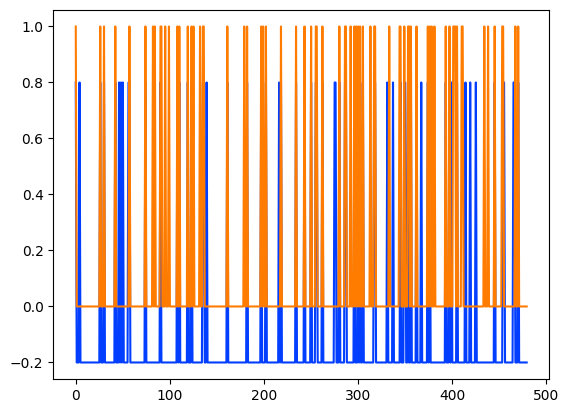

In [52]:
plt.plot(list(xgb_results-0.2))
plt.plot(list(y_test))

In [47]:
confusion_matrix(y_test, xgb_results)

array([[388,  20],
       [ 26,  46]], dtype=int64)

In [55]:
confusion_matrix(y_test, xgb_results)

array([[388,  20],
       [ 26,  46]], dtype=int64)